# Lognormal test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering a fraction of the sky defined by intervals in $\cos\theta$ and $\phi$ with small "veto" regions.

See the [lognormal catalog notebook](lognormal_catalog.ipynb) for more details of the mock catalog and the cells below for the mask.

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../sht')
#
from sht                import DirectSHT
from mocks              import LogNormalMocks
from mask_deconvolution import MaskDeconvolution
from window_function    import make_cl

JAX not found. Falling back to NumPy.
JAX not found. Falling back to NumPy.


In [3]:
# Get a random number generator.
seed = None
rng  = np.random.default_rng(seed)

## Generate a mock catalog and randoms

We start by generating two points sets: the data catalog (from a lognormal model) and the random catalog that implicitly defines the mask, the window function, etc.

In [4]:
# Define our footprint by intervals in cos(theta) and phi.
cthta_min = -0.4
cthta_max =  0.5
theta_min =  np.arccos(cthta_max)
theta_max =  np.arccos(cthta_min)
phi_min   =  0.2
phi_max   =  5.0
#
print("Sky fraction {:f}".format( (phi_max-phi_min)*(cthta_max-cthta_min)/(4*np.pi) ))

Sky fraction 0.343775


In [5]:
# To put more structure in the mask, let's "cut out" various pieces of the
# sky, vetoing both data and random points.
# Generate a random catalog of "veto centers" and "radii".
nveto = 10
tveto = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nveto) )
pveto = rng.uniform(low=phi_min,high=phi_max,size=nveto)
rveto = np.ones_like(tveto) * 0.999
# and convert these into 3D unit vectors
nveto = np.zeros( (nveto,3) )
nveto[:,0] = np.sin(tveto)*np.cos(pveto)
nveto[:,1] = np.sin(tveto)*np.sin(pveto)
nveto[:,2] = np.cos(tveto)

In [6]:
def veto_points(tt,pp,wt,nveto,rveto):
    """Returns 'trimmed' tt, pp, wt arrays vetoed by a set of 'veto' points."""
    nh      = np.zeros( (tt.size,3) )
    nh[:,0] = np.sin(tt)*np.cos(pp)
    nh[:,1] = np.sin(tt)*np.sin(pp)
    nh[:,2] = np.cos(tt)
    ww      = np.ones(tt.size,dtype='bool')
    for i in range(nveto.shape[0]):
        ww &= np.dot(nh,nveto[i,:])<rveto[i]
    return( (tt[ww],pp[ww],wt[ww]) )

In [7]:
# Generate a lognormal mock
npnt_fullsky = 3 * 500000
#
# Initialize a helper object from which to draw realizations
Mocks_obj = LogNormalMocks(npnt_fullsky,nside=2048, 
                           theta_range=[theta_min,theta_max],
                           phi_range=[phi_min,phi_max])
#
# Draw a realization, specifying the random seed if you want
tdata,pdata,wdata = Mocks_obj(seed=0)
#
ndata = len(tdata)
print("Kept {:d} objects in cut.".format(ndata))

gmap in range (-3.978870e+00,3.793611e+00)
emap in range (3.958137e-04,9.398015e-01)
Kept 511226 objects in cut.


In [8]:
# Code to generate a random catalog.
def generate_randoms(nrand):
    """Generate nrand randoms in our footprint."""
    trand = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nrand) )
    prand = rng.uniform(low=phi_min,high=phi_max,size=nrand)
    wrand = np.ones_like(trand) * float(ndata)/float(nrand)
    return( (trand,prand,wrand) )

In [9]:
# Generate the randoms.
nrand = 30*ndata
trand,prand,wrand = generate_randoms(nrand)

In [10]:
# Run the data and randoms through the "veto mask".
tdata,pdata,wdata = veto_points(tdata,pdata,wdata,nveto,rveto)
trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
# Correct for the veto'd points.
ndata  = len(tdata)
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)

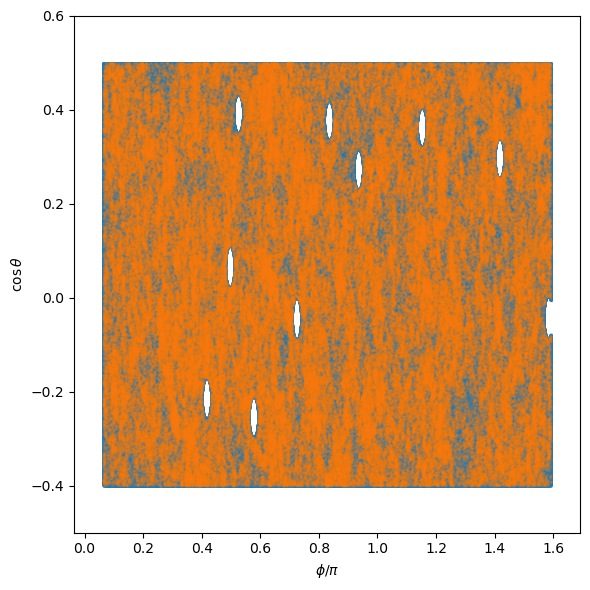

In [11]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(prand/np.pi,np.cos(trand),s=1,c='C0',alpha=0.1,label='Rand',rasterized=True)
ax.scatter(pdata/np.pi,np.cos(tdata),s=1,c='C1',alpha=0.1,label='Data',rasterized=True)
#
ax.set_xlim(phi_min/np.pi-0.1,phi_max/np.pi+0.1)
ax.set_ylim(cthta_min-0.1,cthta_max+0.1)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()

## Harmonic analysis

First do a "direct harmonic analysis" of the data and random points by applying the SHT, differencing, and then computing the psuedo-spectrum.  We will start by finding the window function from the randoms ...

In [12]:
# Set up an sht instance.  We will set Nx to be quite large, so that we are
# confident in our interpolation.
Nl   = 2**8
Nl   = 350
Nx   = 4*Nl+1
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 350 , Nx= 1401  and xmax= 0.625
For randoms, Direct SHT has Nl= 414 , Nx= 1401  and xmax= 0.625


In [13]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl) - sn

Sorting took  3.7804677486419678  seconds.
Digitizing & reshaping took  6.122155666351318  seconds.
Precomputing vs took  574.0306580066681  seconds.
Computing alm's took  4.781484603881836  seconds.
Sorting took  3.3422329425811768  seconds.
Digitizing & reshaping took  6.992372751235962  seconds.
Precomputing vs took  445.591500043869  seconds.
Computing alm's took  5.367353677749634  seconds.


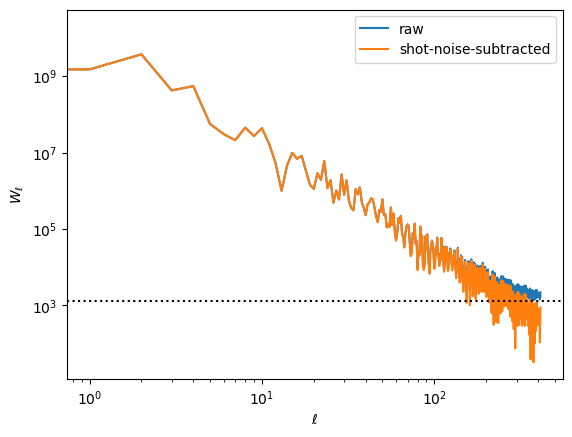

In [14]:
plt.loglog(wl+sn,label='raw')
plt.loglog(wl   ,label='shot-noise-subtracted')
plt.axhline(sn,ls=':',color='k')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 1min 15s, sys: 373 ms, total: 1min 15s
Wall time: 1min 15s
[1.00007179 1.00005092 1.00004551 1.00004686 1.00005711 1.00006202
 1.00006247 1.00006336 1.00007534 1.0000904  1.00009572 1.00009808
 1.00011313 1.00014373 1.00016657 1.00018031 1.00021403 1.00029481
 1.00039123 1.0004821  1.00061989 1.00100989 1.00215029 1.00268079
 1.06141035]


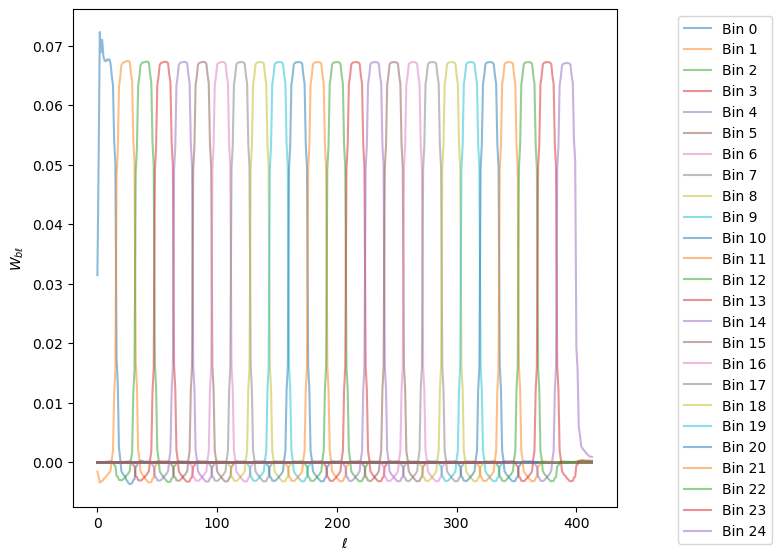

In [15]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**4
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print(Mbl.sum(axis=1))
# and plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()

Sorting took  0.05390739440917969  seconds.
Digitizing & reshaping took  2.9051918983459473  seconds.
Precomputing vs took  9.848650932312012  seconds.
Computing alm's took  2.7789053916931152  seconds.
Sorting took  0.04124164581298828  seconds.
Digitizing & reshaping took  2.669482946395874  seconds.
Precomputing vs took  9.0305917263031  seconds.
Computing alm's took  2.159245252609253  seconds.
Sorting took  2.9680111408233643  seconds.
Digitizing & reshaping took  4.252972602844238  seconds.
Precomputing vs took  459.3708481788635  seconds.
Computing alm's took  2.665120840072632  seconds.
Sorting took  2.409475088119507  seconds.
Digitizing & reshaping took  3.638037919998169  seconds.
Precomputing vs took  339.3414635658264  seconds.
Computing alm's took  2.1393795013427734  seconds.
hatC in range [8.614217e+04,2.989526e+07]


Text(0, 0.5, '$\\hat{C}_\\ell$')

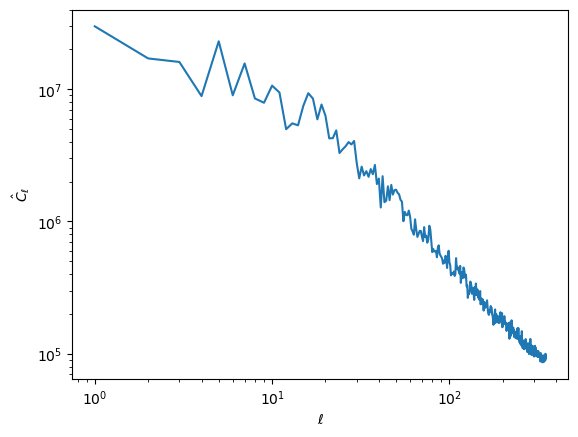

In [16]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [17]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [18]:
print(binned_ells)
print(hdif_decoupled)

[ 39.5  55.5  71.5  87.5 103.5 119.5 135.5 151.5 167.5 183.5 199.5 215.5
 231.5 247.5 263.5 279.5 295.5 311.5 327.5 343.5 359.5]
[ 4.05412285e-04  2.66803801e-04  1.68879150e-04  1.16604042e-04
  9.57488442e-05  8.20568649e-05  6.31428280e-05  5.33195014e-05
  4.57769897e-05  3.83783812e-05  3.87701471e-05  3.26897887e-05
  3.08418830e-05  2.83294524e-05  2.51017831e-05  2.33996965e-05
  2.20392025e-05  2.18817664e-05  2.02377786e-05  1.81300371e-05
 -1.46361801e-06]


Text(0, 0.5, '$\\tilde{C}_\\ell$ (direct SHT)')

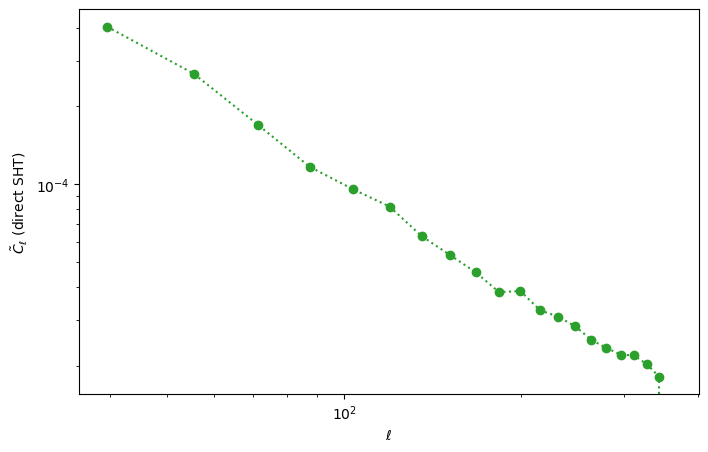

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Diff')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$ (direct SHT)')

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [20]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

0.0 180.0 -180.0 180.0


dmap.sum= 31507794870.50734
rmap.sum= 31507794870.5421
Have 117490.99 randoms per non-empty pixel.
fsky= 0.2533149719238281


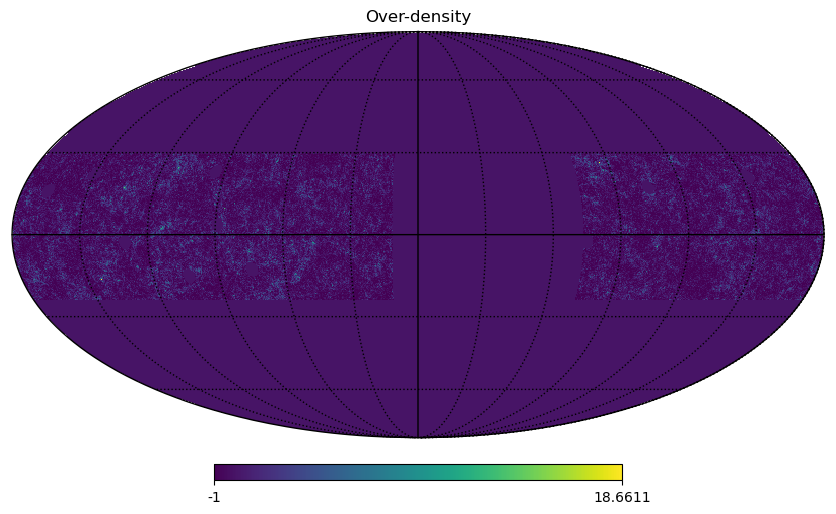

In [21]:
# Show an example at some nside.
# Eventually want to plot in grey the masked region
# and make it look pretty.
nside= 256
npix = 12*nside**2
dmap = make_map(tdata,pdata,wdata,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
#
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
print("Have {:8.2f} randoms per non-empty pixel.".format(avg))
msk = np.nonzero(rmap>0.5*avg)[0]
#
omap      = np.zeros(npix,dtype='f8')
omap[msk] = dmap[msk]/rmap[msk]
omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
mask      = np.zeros(npix)
mask[msk] = 1.0
#
fsky = len(np.nonzero(dmap>0)[0])/float(len(dmap))
print("fsky=",fsky)
#
hp.mollview(omap,title='Over-density')
hp.graticule()

Text(0, 0.5, '$\\hat{C}_\\ell$')

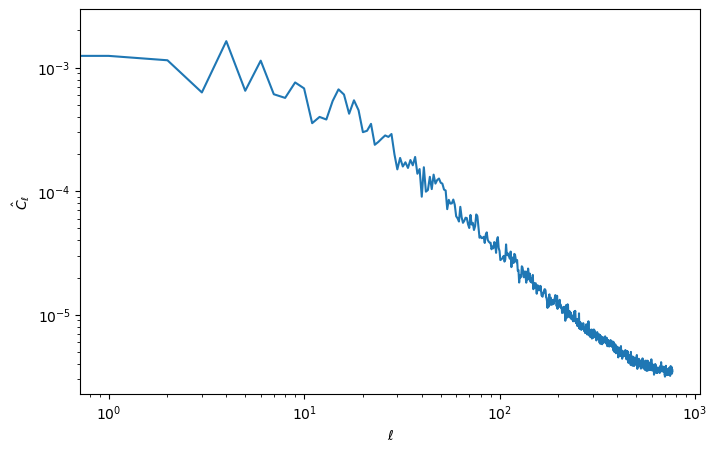

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
#
cl_via_map = hp.anafast(omap)
ax.loglog(cl_via_map[1:-1])
#
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')

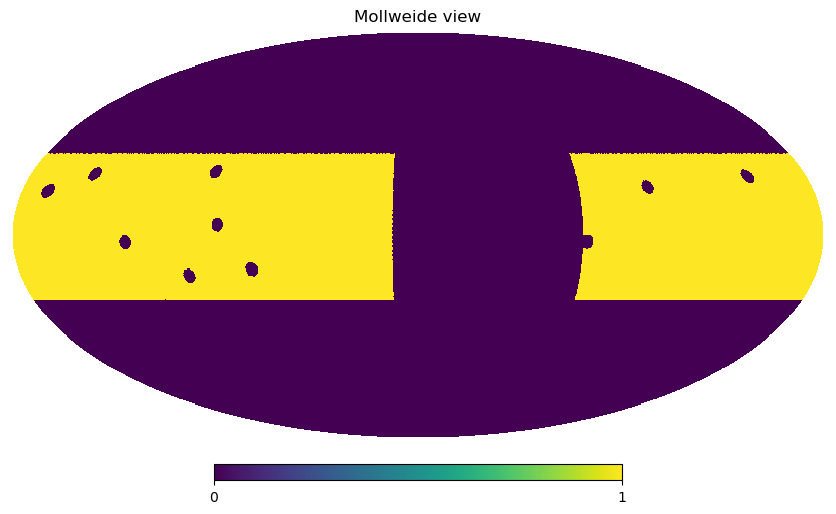

In [23]:
# Measure the W_l
wl_maplevel = hp.anafast(mask)
hp.mollview(mask)

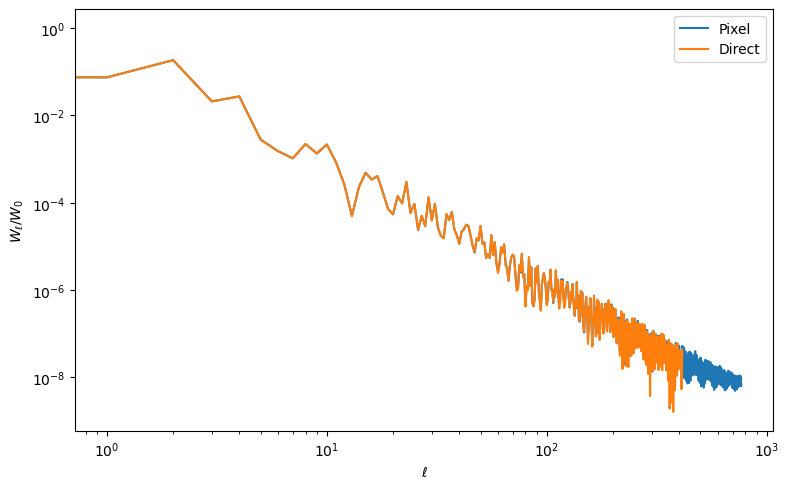

In [24]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.loglog(wl_maplevel/wl_maplevel[0],label='Pixel')
ax.loglog(wl/wl[0],label='Direct')
#
ax.legend()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_\ell/W_0$')
#
plt.tight_layout()

In [25]:
# We need to initialize a different mode-decoupling object
# because our map-level mask has a different normalization
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)
#
# Deconvolve the mask to produce a "map delta" estimate of tilde{C}_ell.
binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard], mdel_decoupled[Ndiscard:-Ndiscard]

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


(1e-05, 0.001)

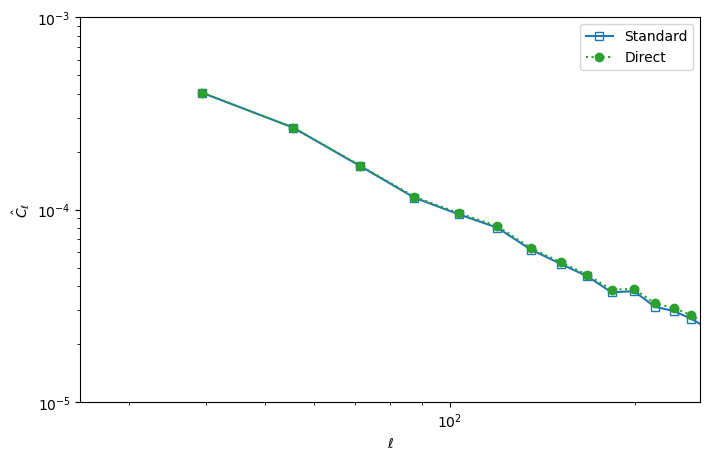

In [26]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,mdel_decoupled,'s-',color='C0',mfc='None',label='Standard')
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')
ax.set_xlim([25,256])
ax.set_ylim([1e-5,1e-3])

# How many randoms are needed?

As the pixelization is made finer, more and more pixels within the footprint will lack randoms. This is a problem when defining the overdensity as a ratio of data-to-randoms.

For Nrandoms=15116427


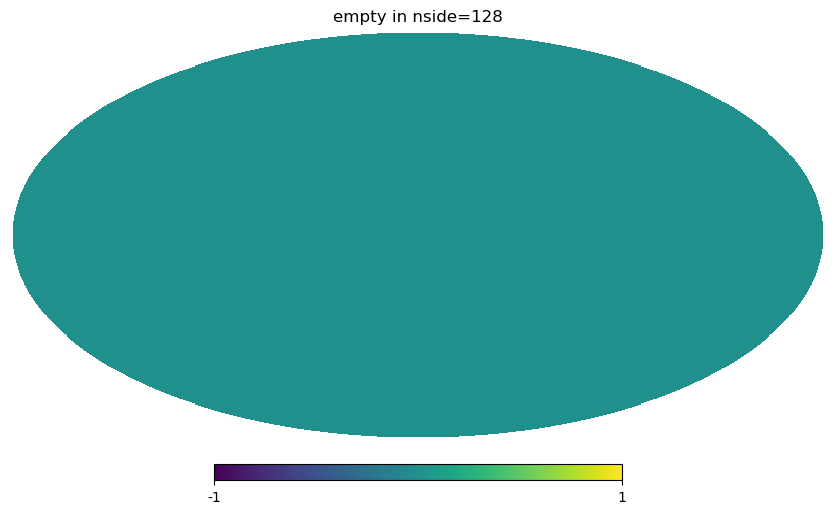

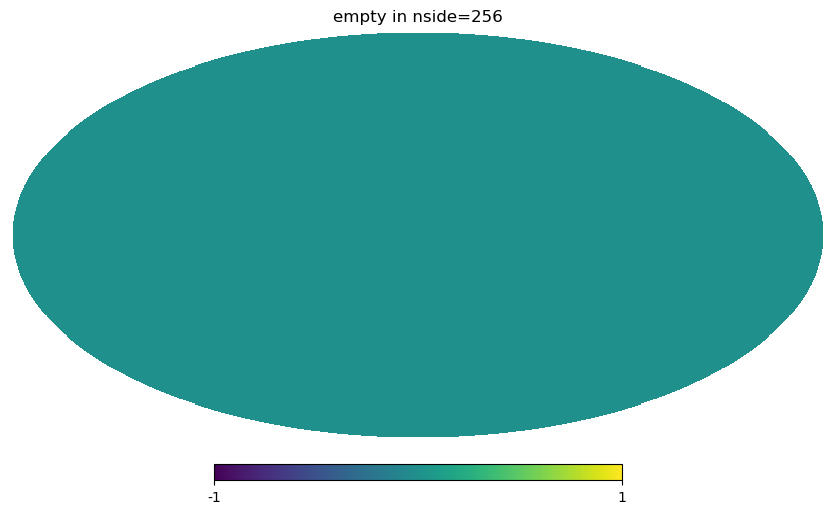

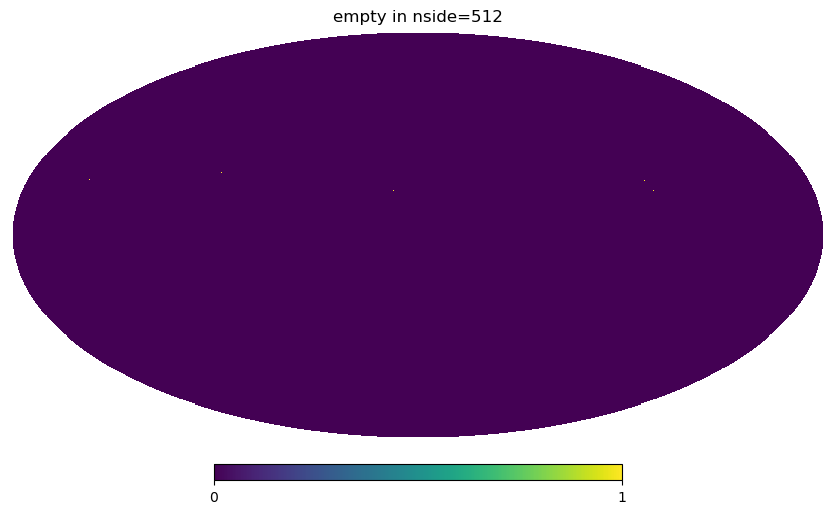

In [27]:
print('For Nrandoms={}'.format(nrand))
for nside in [128, 256, 512]:
    map_mask = hp.ud_grade(mask,nside)
    rmap = make_map(trand,prand,wrand,nside)
    empty_pix_in_mask = np.logical_not(rmap) * map_mask
    hp.mollview(empty_pix_in_mask, title='empty in nside={}'.format(nside))

# Compare to standard analysis as a function of nside

Now we can compare the direct SHT approach to the standard one, with the latter using a number of randoms adapted to the pixelization 

In [28]:
factor = 30 # The ratio of randoms to pixels

In [30]:
# Let's save ourselves some time by using the same W_l irrespective of the number of randoms
# To give ourselves the best chance, compute this at high resolution.
nside = 512
npix  = 12*nside**2
nrand = int(factor*hp.nside2npix(nside)*fsky)
trand,prand,wrand = generate_randoms(nrand)
trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)
#
# Make a binary mask.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
print("Have {:8.2f} randoms per non-empty pixel.".format(avg))
msk = np.nonzero(rmap>0.5*avg)[0]
#
mask      = np.zeros(npix)
mask[msk] = 1.0
# Measure the W_l and trim it to the same size as our direct W_l.
wl_maplevel = hp.anafast(mask)
wl_maplevel = wl_maplevel[:wl.size]

Have 117931.41 randoms per non-empty pixel.


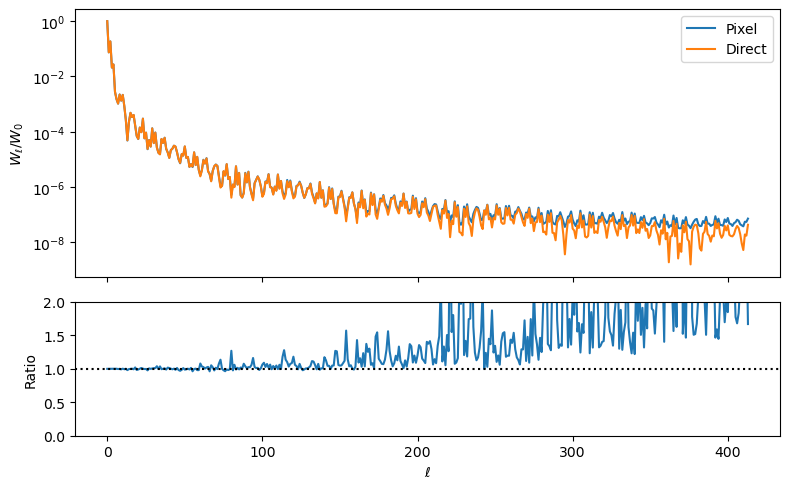

In [31]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(2,1,sharex=True,figsize=(8,5),\
                      gridspec_kw={'height_ratios':[2,1]})
#
ells = np.arange(wl_maplevel.size)
ax[0].plot(ells,wl_maplevel/wl_maplevel[0],label='Pixel')
ax[0].plot(ells,wl/wl[0],label='Direct')
#
ax[1].plot(ells,(wl_maplevel/wl_maplevel[0])/(wl/wl[0]))
ax[1].axhline(1.0,ls=':',color='k')
#
ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_ylim(0,2)
ax[1].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$W_\ell/W_0$')
ax[1].set_ylabel(r'Ratio')
#
plt.tight_layout()

In [32]:
# Make a mode-decoupling object to go with the mask.
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


In [ ]:
fig,ax = plt.subplots(1,2,sharey=False,figsize=(8,4.2))
#
ax[0].loglog(binned_ells,hdif_decoupled,'s-',mfc='None')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\tilde{C}_\ell$')
#
icol= 0
for nside in [256,512,1024]:
    npix  = 12*nside**2
    # Generate a random catalog.
    nrand = int(factor*hp.nside2npix(nside)*fsky)
    print('For Nrandoms={}'.format(nrand))
    trand,prand,wrand = generate_randoms(nrand)
    trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
    wrand *= np.sum(wdata)/np.sum(wrand)
    #
    dmap = make_map(tdata,pdata,wdata,nside)
    rmap = make_map(trand,prand,wrand,nside)
    #
    print("dmap.sum=",np.sum(dmap))
    print("rmap.sum=",np.sum(rmap))
    # Remove pixels where we have data but no randoms,
    # then generate the 1+delta field.
    msk = np.nonzero(rmap>0)[0]
    avg = np.mean(rmap[msk])
    print("Have {:8.2f} randoms per non-empty pixel.".format(avg))
    msk = np.nonzero(rmap>0.5*avg)[0]
    #
    omap      = np.zeros(npix,dtype='f8')
    omap[msk] = dmap[msk]/rmap[msk]
    omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
    mask      = np.zeros(npix)
    mask[msk] = 1.0
    #   
    cl_via_map = hp.anafast(omap)
    #
    # Deconvolve the mask
    binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
    binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard],mdel_decoupled[Ndiscard:-Ndiscard]
    #
    ratio= hdif_decoupled/mdel_decoupled
    pixwn= hp.pixwin(nside)
    #
    ax[1].plot(binned_ells,ratio,'s-',color='C'+str(icol),alpha=0.5,\
               mfc='None',label='${:4d}$'.format(nside))
    ax[1].plot(np.arange(pixwn.size),pixwn,ls=':',color='C'+str(icol))
    icol = (icol+1)%10
ax[1].axhline(1.0,ls=':',color='k')
ax[1].set_ylabel(r'Power ratio (map/harmonic)')
ax[1].legend(title=r'$N_{\rm side}$')
ax[1].set_ylim(0.0,2.0)
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlim([0,Nl])
#
plt.tight_layout()
#plt.savefig('compare_pipelines.pdf')

# The End